# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [21]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13565732314846708769
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17785781745348455791
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3424967068221050748
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 2416703581551796592
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:86:00.0, compute capability: 3.5"
]


In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = "/mnt/scratch/students/"#f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [4]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [5]:
projections = data['Projections']
projections.shape

(5000, 275, 275)

In [6]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

#### True Angles

In [7]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

---

## Prepare for training

In [8]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [9]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [10]:
X_max_px = np.max(X)
X = X/X_max_px
print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to 59.803096771240234


In [11]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [12]:
np.savez("data/5a1a/5a1a_siamese_idx", train_idx, val_idx, test_idx)

In [13]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [14]:
# TODO: increase these values, it is just important to have the batches small enough
start_time = time.time()

tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=80000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

print(f"{time.time()-start_time:.0f}s")

1423s


# 1. Distance Estimation

### Train the model

In [13]:
# %tensorboard --logdir training

In [15]:
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

In [ ]:
model, history = train_siamese(training_pairs=tr_pairs, 
              training_y=tr_y, 
              validation_pairs=val_pairs, 
              validation_y=val_y, 
              epochs=500, 
              batch_size=256, 
              learning_rate=0.001,  #0.001 
              plot=True)

Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          184576      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0     

Epoch 25/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.5684 - mse: 0.4858
Epoch 00025: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.5684 - mse: 0.4859 - val_loss: 0.6143 - val_mse: 0.5520
Epoch 26/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.5623 - mse: 0.4763
Epoch 00026: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.5624 - mse: 0.4765 - val_loss: 0.6186 - val_mse: 0.5733
Epoch 27/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.5516 - mse: 0.4591
Epoch 00027: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.5516 - mse: 0.4591 - val_loss: 0.6192 - val_mse: 0.5662
Epoch 28/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.5296 - mse: 0.4285
Epoch 00028: saving model to training/20200418_032354
80000/800

79872/80000 [============================>.] - ETA: 0s - loss: 0.1968 - mse: 0.0668
Epoch 00083: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1967 - mse: 0.0668 - val_loss: 0.6914 - val_mse: 0.8023
Epoch 84/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1965 - mse: 0.0664
Epoch 00084: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1964 - mse: 0.0664 - val_loss: 0.6907 - val_mse: 0.8028
Epoch 85/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1966 - mse: 0.0665
Epoch 00085: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1966 - mse: 0.0665 - val_loss: 0.6931 - val_mse: 0.8087
Epoch 86/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1955 - mse: 0.0660
Epoch 00086: saving model to training/20200418_032354
80000/80000 [=========

79872/80000 [============================>.] - ETA: 0s - loss: 0.1854 - mse: 0.0600
Epoch 00141: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1855 - mse: 0.0600 - val_loss: 0.7020 - val_mse: 0.8326
Epoch 142/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1860 - mse: 0.0601
Epoch 00142: saving model to training/20200418_032354
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1860 - mse: 0.0601 - val_loss: 0.7064 - val_mse: 0.8412
Epoch 143/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1862 - mse: 0.0603
Epoch 00143: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1862 - mse: 0.0603 - val_loss: 0.7224 - val_mse: 0.8720
Epoch 144/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1861 - mse: 0.0605
Epoch 00144: saving model to training/20200418_032354
80000/80000 [======

79872/80000 [============================>.] - ETA: 0s - loss: 0.1809 - mse: 0.0576
Epoch 00199: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1810 - mse: 0.0576 - val_loss: 0.7151 - val_mse: 0.8571
Epoch 200/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1806 - mse: 0.0571
Epoch 00200: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1805 - mse: 0.0571 - val_loss: 0.7098 - val_mse: 0.8442
Epoch 201/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1797 - mse: 0.0566
Epoch 00201: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1797 - mse: 0.0566 - val_loss: 0.7092 - val_mse: 0.8440
Epoch 202/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1798 - mse: 0.0568
Epoch 00202: saving model to training/20200418_032354
80000/80000 [======

79872/80000 [============================>.] - ETA: 0s - loss: 0.1727 - mse: 0.0527
Epoch 00257: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1727 - mse: 0.0527 - val_loss: 0.7302 - val_mse: 0.8834
Epoch 258/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1738 - mse: 0.0532
Epoch 00258: saving model to training/20200418_032354
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1738 - mse: 0.0532 - val_loss: 0.7379 - val_mse: 0.9012
Epoch 259/500
55552/80000 [===================>..........] - ETA: 31s - loss: 0.1717 - mse: 0.0523

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
mses = history.history['mse']
val_mses = history.history['val_mse']

np.savez("data/5a1a/5a1a_DE_history", training_loss, val_loss, mses, val_mses)

In [19]:
import matplotlib.pyplot as plt

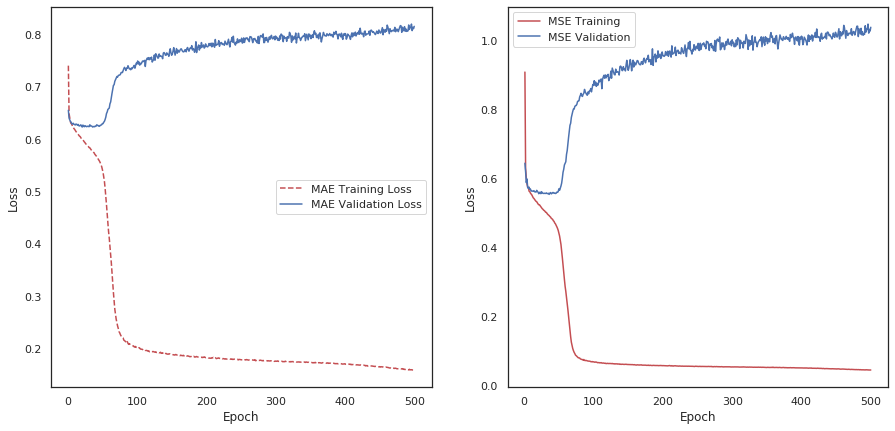

In [20]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [13]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200409_164021.h5" # symmetric protein (finally), 1K training, 32 batch size, 500 epochs

In [14]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 275, 275, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 275, 275, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [15]:
from cryoem.distance_estimation import plot_results

In [17]:
y_tr_pred = model.predict_on_batch([tr_pairs[:32, 0], tr_pairs[:32, 1]])
y_val_pred = model.predict_on_batch([val_pairs[:32, 0], val_pairs[:32, 1]])

In [19]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 1.5927114486694336
true:      2.108511789712276
mse:       0.26604989171028137
mae:       0.5158002376556396


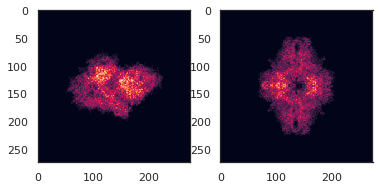

In [20]:
plot_train_results(1)

--- Validation Set ---
predicted: 1.4536620378494263
true:      1.0166318301395656
mse:       0.19099539518356323
mae:       0.43703019618988037


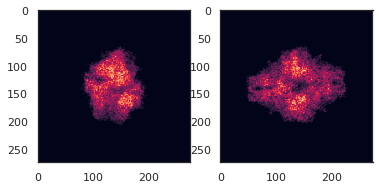

In [21]:
plot_validation_results(0)

---

## dP/dQ plot

In [23]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [24]:
def d_p(p1, p2):
    p1 = tf.convert_to_tensor(p1)
    p1 = tf.expand_dims(p1, len(p1.shape)) 
    p2 = tf.convert_to_tensor(p2)
    p2 = tf.expand_dims(p2, len(p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 
    return model.predict_on_batch([p1, p2])

In [29]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=64))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=64))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

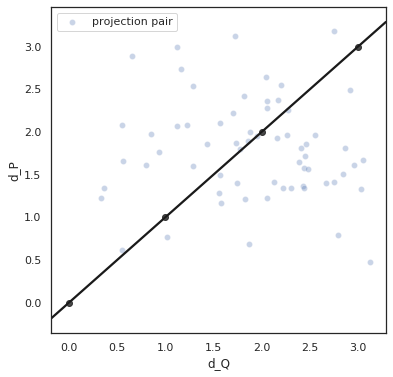

In [30]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

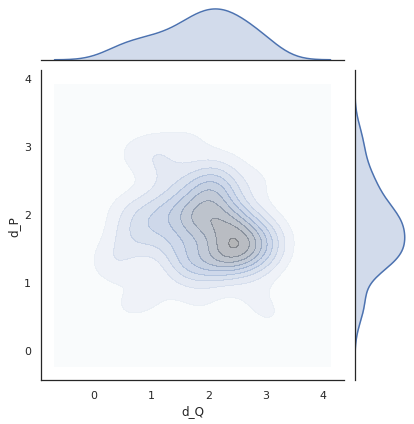

In [31]:
plot_dP_dQ_density(dP_values, dQ_values)

In [32]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.9888198490460155

# 2. Angle Recovery

In [25]:
from cryoem.angle_recovery import train_angle_recovery

###### Predicted Angles (initialization)

In [26]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
angles_predicted = [tf.Variable(e, dtype=tf.float32) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

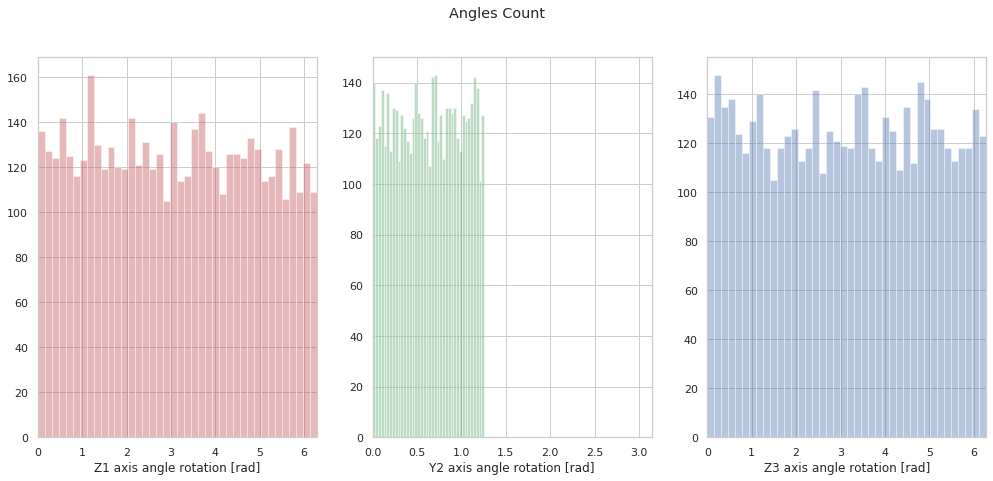

In [27]:
plot_angles_count(angles_predicted)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [28]:
from cryoem.angle_recovery import train_angle_recovery

In [ ]:
train_angle_recovery(steps=300000, 
                     batch_size=256, 
                     projection_idx=test_idx, 
                     angles_predicted=angles_predicted, 
                     est_dist_input=X, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

step 30000/300000 (39977s): loss = 8.10e-01
step 60000/300000 (79735s): loss = 8.21e-01
step 90000/300000 (119528s): loss = 7.53e-01
step 120000/300000 (159297s): loss = 7.81e-01
step 150000/300000 (199028s): loss = 8.84e-01
step 180000/300000 (238759s): loss = 8.15e-01
step 210000/300000 (278414s): loss = 8.80e-01
step 240000/300000 (318061s): loss = 7.84e-01


In [34]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_siamese1_Xnorm.npy", ang_save)

In [35]:

#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_siamese1_Xnorm.npy")

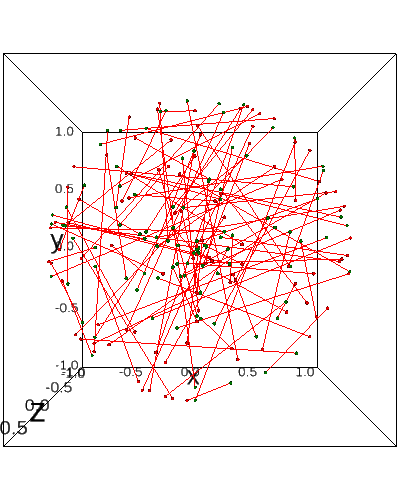

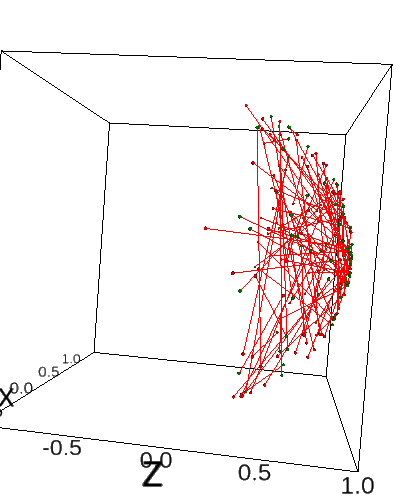

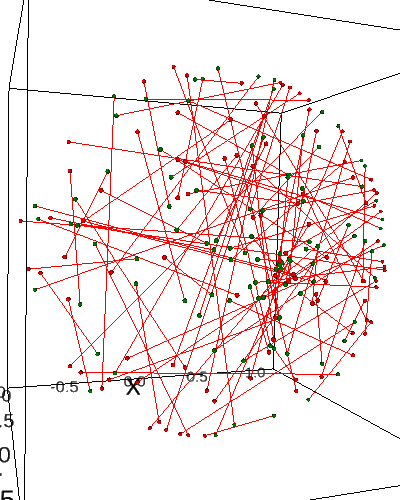

In [36]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [39]:
display(ipv.screenshot())

Output()

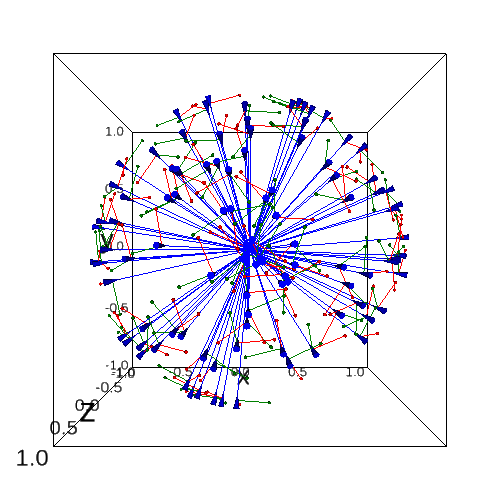

In [40]:
plot_rays(ap, indices=range(100))

In [41]:
display(ipv.screenshot())

Output()

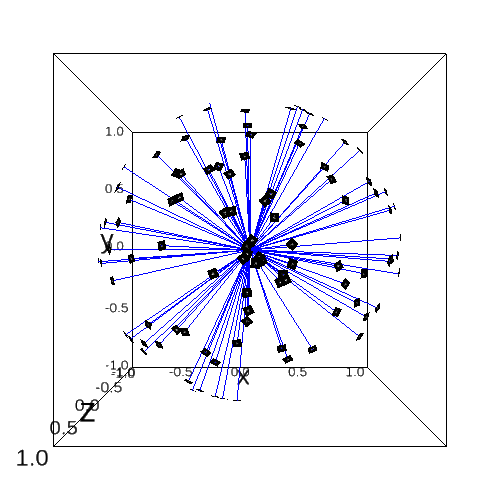

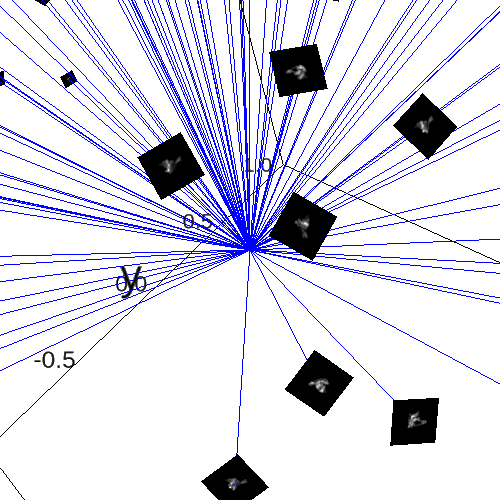

In [45]:
plot_images(ap, data['Projections'], indices=range(100),img_size_scale=0.05)

In [47]:
display(ipv.screenshot())

Output()

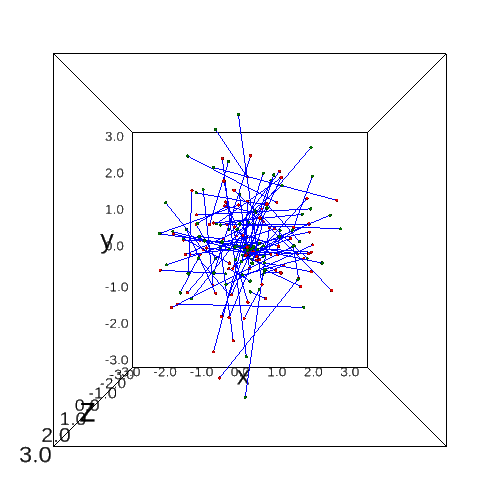

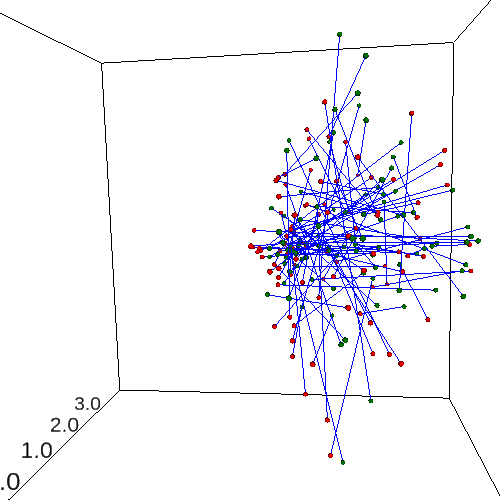

In [48]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [50]:
display(ipv.screenshot())

Output()

### Alignment

### Angle Alignment

In [12]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [13]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.8753162350501303
Geodesic distance:  0.9354977009682132  rad ( 53.60007000967016  degrees)
Quaternion distance:  1.8792453646910081


(0.8753162350501303, 0.9354977009682132, 1.8792453646910081)

FLIPPING: (1, 1, 1)
step 300/3000 (20s): loss = 1.89e+00
step 600/3000 (42s): loss = 1.86e+00
step 900/3000 (62s): loss = 1.84e+00
step 1200/3000 (83s): loss = 1.92e+00
step 1500/3000 (104s): loss = 1.85e+00
step 1800/3000 (125s): loss = 1.92e+00
step 2100/3000 (146s): loss = 1.82e+00
step 2400/3000 (167s): loss = 1.84e+00
step 2700/3000 (188s): loss = 1.85e+00
step 3000/3000 (208s): loss = 1.84e+00
Rotation: [-0.00490297 -0.02711936  0.1426672 ];  Loss: 1.8367986426233545
FLIPPING: (1, 1, -1)
step 300/3000 (21s): loss = 1.90e+00
step 600/3000 (43s): loss = 1.85e+00
step 900/3000 (65s): loss = 1.95e+00
step 1200/3000 (87s): loss = 1.85e+00
step 1500/3000 (110s): loss = 1.86e+00
step 1800/3000 (133s): loss = 1.80e+00
step 2100/3000 (155s): loss = 1.92e+00
step 2400/3000 (177s): loss = 1.84e+00
step 2700/3000 (201s): loss = 1.89e+00
step 3000/3000 (223s): loss = 1.84e+00
Rotation: [ 1.04681434 -0.00745438  1.07037117];  Loss: 1.8383151868526857
FLIPPING: (1, -1, 1)
step 300/3000 (24s): l

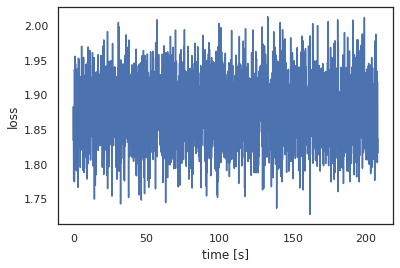

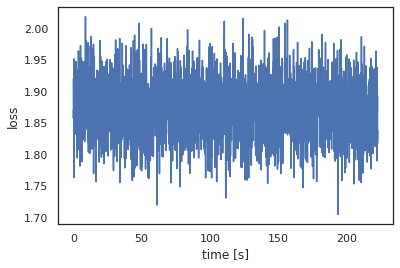

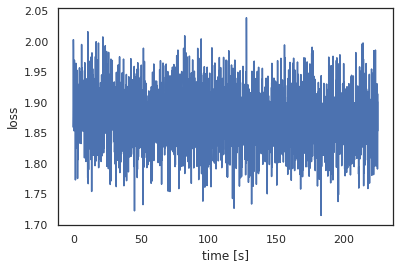

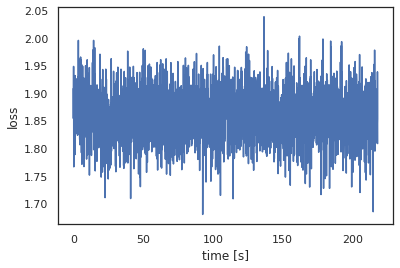

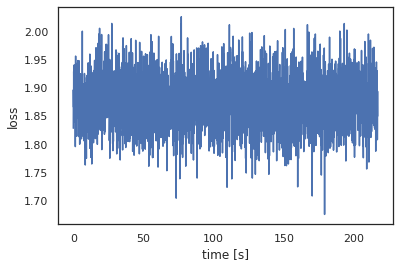

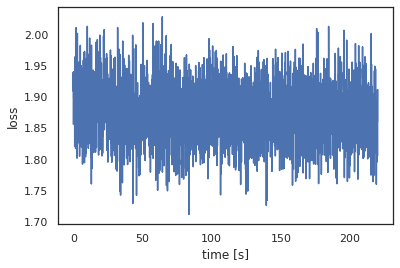

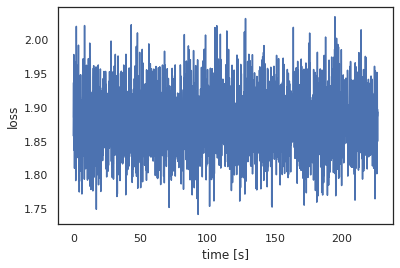

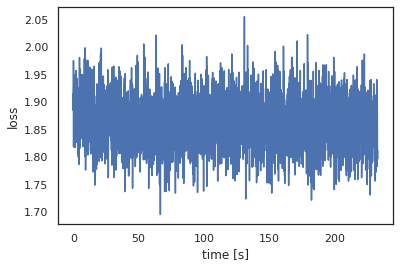

In [14]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=3000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [15]:
flips, a_R, loss

((-1, 1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.13859976, 0.00403881, 1.17981399])>],
 1.805538792924037)

In [16]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [17]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.8891816409860227
Geodesic distance:  0.9527709741869989  rad ( 54.58975566348293  degrees)
Quaternion distance:  1.8733542515433756


(0.8891816409860227, 0.9527709741869989, 1.8733542515433756)

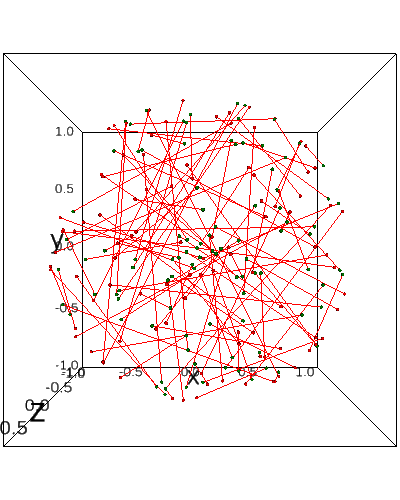

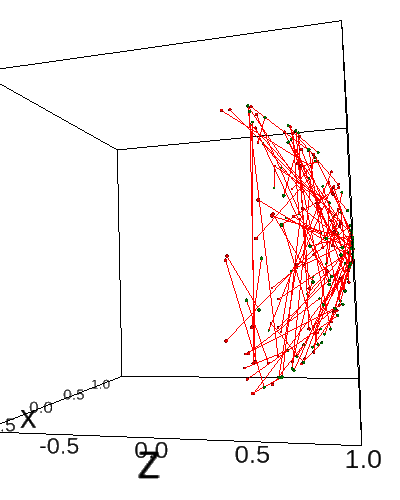

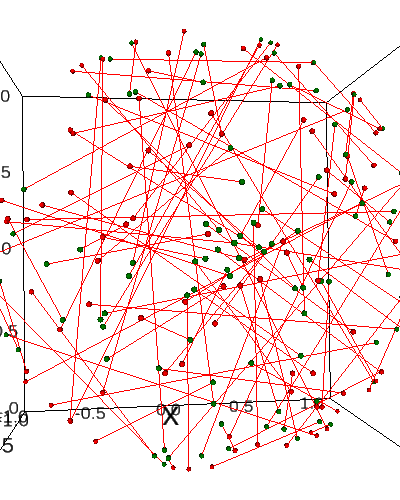

In [19]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [22]:
import ipyvolume as ipv

display(ipv.screenshot())

Output()

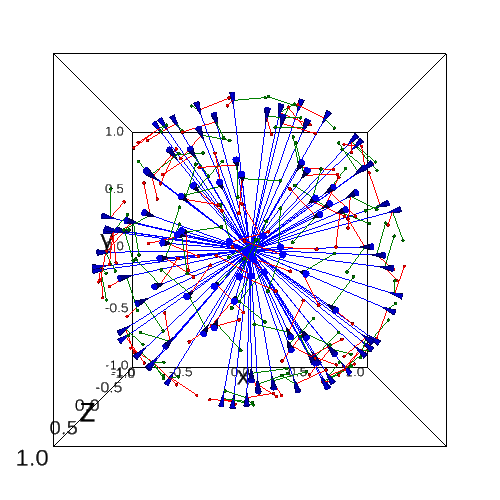

In [23]:
plot_rays(angles_predicted_new, range(100))

In [24]:
display(ipv.screenshot())

Output()

In [25]:
projections = data["Projections"]

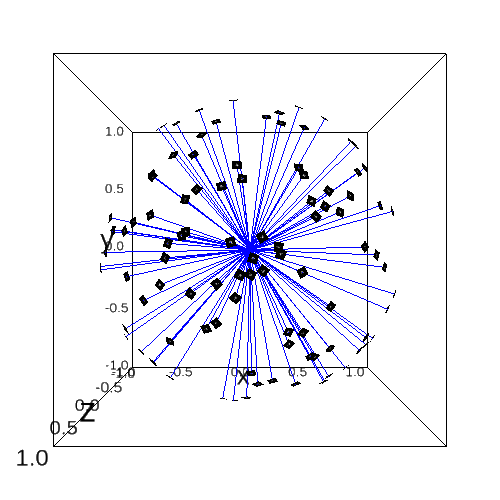

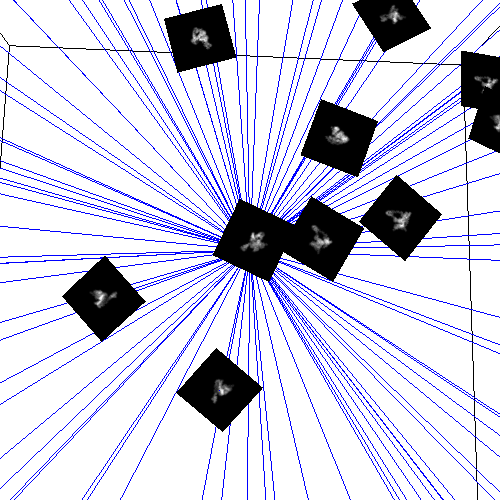

In [26]:
from cryoem.plots import plot_images
plot_images(angles_predicted_new, projections, indices=range(100),img_size_scale=0.05)

In [28]:
display(ipv.screenshot())

Output()

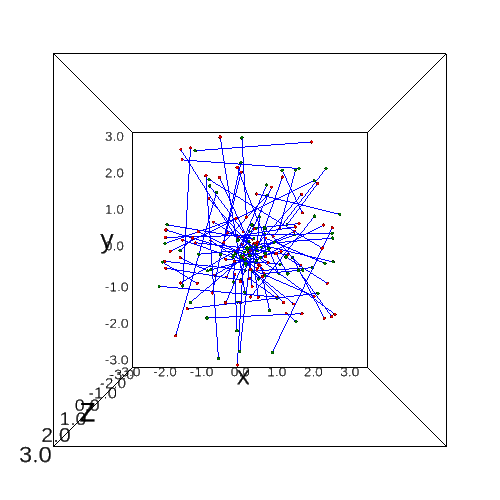

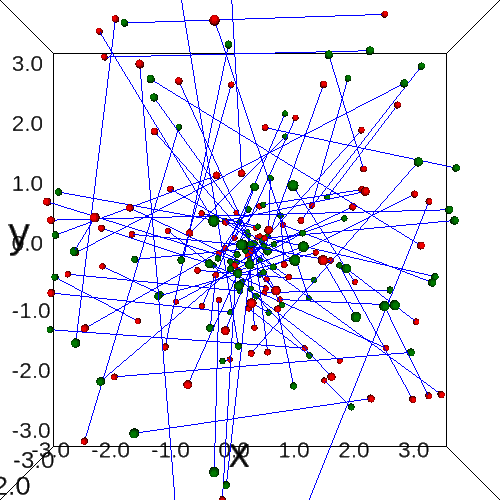

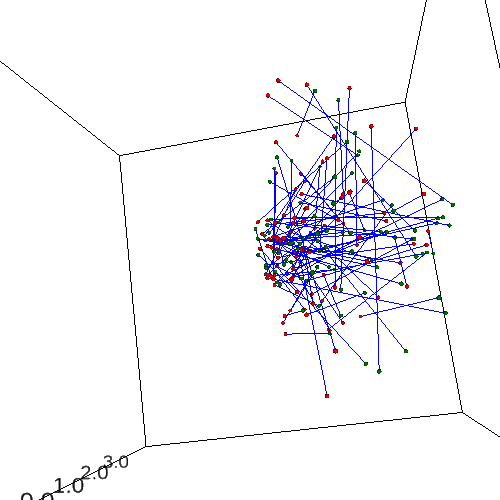

In [29]:
from cryoem.plots import plot_selected_angles_with_3rd_angle_magnitude

plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [32]:
display(ipv.screenshot())

Output()